In [1]:
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
 
sns.set()
plt.style.use('seaborn-colorblind')
pd.options.display.max_colwidth = 400

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from nltk.tokenize import word_tokenize, sent_tokenize,RegexpTokenizer

C:\Users\testi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


# Read in corpus.pkl

___

Here we are going to change the name of our target column and binarize it. 

|value|subreddit|
|---|---|
|1|r/facts|
|0|r/FakeFacts|

In [2]:
with open('corpus.pkl','rb') as clean_pickle:
    corpus = pickle.load(clean_pickle)

In [3]:
corpus.selftext.str.contains('of').sum()

630

In [4]:
# rename
corpus.rename(columns={"subreddit":"fact"}, inplace = True)
# binarize
corpus.fact = np.where(corpus.fact == 'facts', 1,0)

In [5]:
corpus.fact.value_counts(normalize = True )

1    0.543085
0    0.456915
Name: fact, dtype: float64

# Functions

___

## HUD

In [6]:
# diplays preview of dataframe for checking changes

base_group = corpus.groupby(['fact']).mean()
head = corpus.head(2)
hud = [base_group,head]
disp = ['mean','preview']
def disp_hud(hud):
    for i,li in enumerate(hud):
        print(disp[i])
        display(li)
        
disp_hud(hud)

mean


,selftext_length
fact,
0,176.398177
1,187.203667


preview


,fact,selftext,selftext_length
0,0,"The origin the word ""yeet"" in old english .",50
1,0,Did know LEGO named the phrase “let’s ”? In 1877 company named “let’s ” a new toy named LEGO,117


# EDA on character length

___

For the purpose of plotting lets go ahead and make 2 dataframe's one for each subreddit.

In [7]:
fact = corpus.fact == 1
fact_df = corpus[fact]
fiction = corpus.fact == 0 
fiction_df = corpus[fiction]

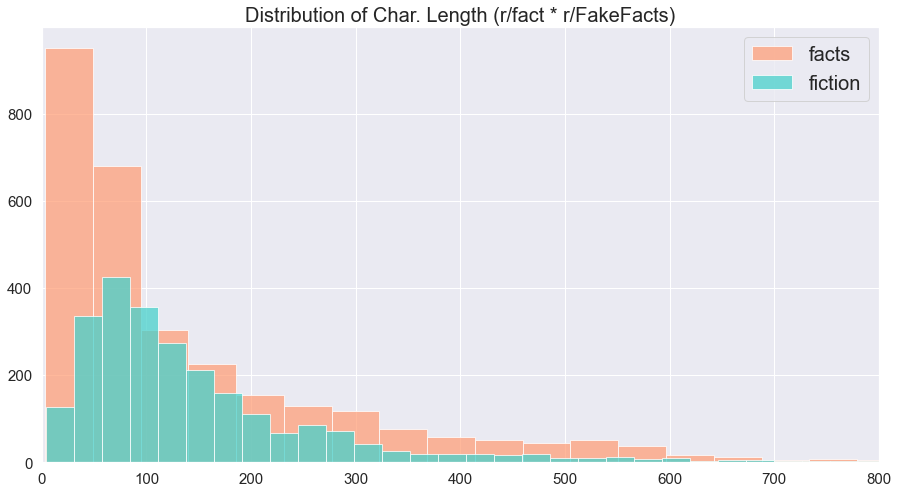

In [8]:
plt.figure(figsize = (15,8))

# plot distributions

# r/facts
plt.hist(fact_df.selftext_length, bins = 200, alpha = 0.75, label = 'facts', color = 'lightsalmon')
# r/FakeFacts
plt.hist(fiction_df.selftext_length, bins = 200, alpha = 0.75, label = 'fiction', color = 'mediumturquoise')

plt.colormaps()

# we have a fiew outliers to deal with so for now we limit the X axis.
plt.xlim(0,800);
# set legend fontsize
plt.legend(fontsize = 20)
# set title
plt.title('Distribution of Char. Length (r/fact * r/FakeFacts)', fontsize = 20)

# set axis font size 
plt.yticks(fontsize = 15);
plt.xticks(fontsize = 15);
plt.savefig('distribution.png')

We noticed some serious outliers in our initial EDA. though they are anomolous, we don't need to remove them for now, let's just look at them to get an idea of whether or not ignoring them in visualization is ok.

In [9]:
corpus.selftext_length.sort_values(ascending = False).head(15)

5133    9135
1698    5912
1697    5906
5139    5659
2015    5356
1908    5304
1985    5230
4819    5021
1115    4381
5145    3660
1539    3522
3240    3207
5200    3009
4531    2848
3159    2774
Name: selftext_length, dtype: int64

In [10]:
corpus.iloc[[5133]]

,fact,selftext,selftext_length
5133,1,"Chinese police trained counter -terrorism tactics Israel prior Beijing Olympics : How might worsened China deals protests civilian uprisings # Israeli Police Trained Chinese Counterparts Prior Olympics Haifa stadium turned mock Beijing Bird 's Nest -week course riot control counter terror . **https://www.haaretz.com/1.5038565** “The training involved , other things , neutralize terrorists bare...",9135


It looks like we have fewer than 15 observations that are skewing our numbers. When we ignore the outliers and look closer, we see that r/facts post's are only lightly larger on average than those of r/FakeFacts. The large posts are legitimate and usable after inspection so we will keep them. 

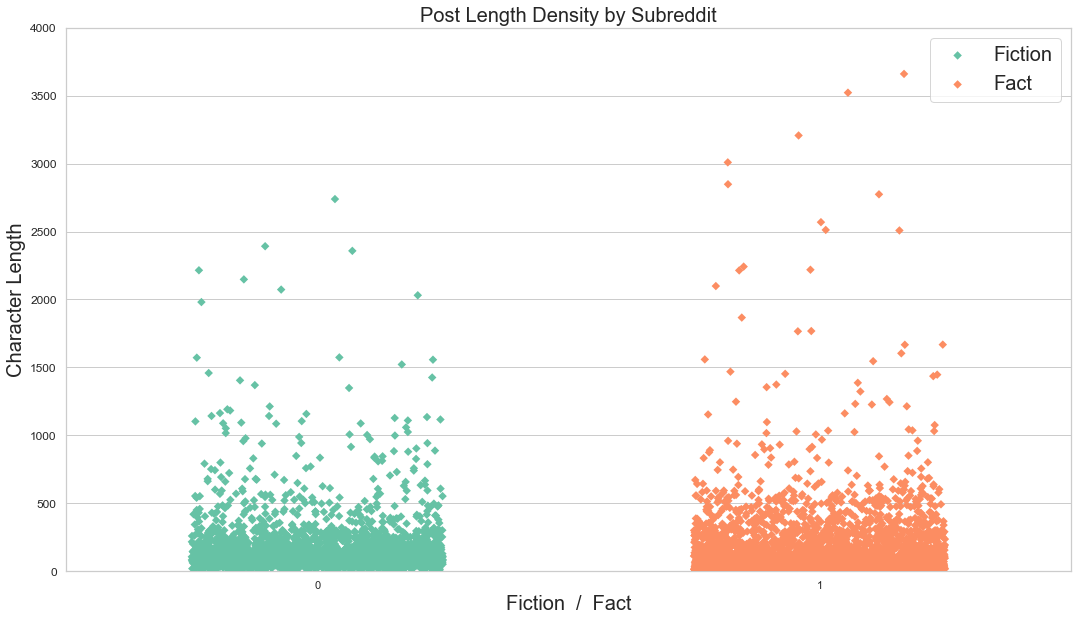

In [11]:
plt.figure(figsize = (18,10))
sns.set_style('whitegrid')
sns.stripplot(x="fact", y="selftext_length", data=corpus,
             jitter = 0.25,
             palette = 'Set2',
             size = 6,
             marker = 'D');
plt.ylim(0,4_000);
plt.yticks(fontsize = 12)
plt.ylabel('Character Length', fontsize = 20)
plt.xlabel('Fiction  /  Fact',fontsize = 20)
plt.title('Post Length Density by Subreddit', fontsize = 20);
plt.legend(['Fiction','Fact'], fontsize = 20);
plt.savefig('Post Lenght Density.png')

In [12]:
corpus.iloc[[1564]]

,fact,selftext,selftext_length
1564,1,Im hungry,11


In [13]:
# corpus = corpus[corpus['selftext_length'] > 10]

What is more concerning is these low numbers. They appear to be posts with no text. that is not useful. We are going to remove anything that has less than 10 characters, or anything that would likely be less than two words. Our character length is a bit off from what you would expect since our count includes spaces and some commas which have since been removed, this is ok as it preserves the original length of the post.

So far we can see that their is a slight but noticable difference in the length of the posts. This is not likely going to be enough of a difference to seriously effect our results. Post length may turn out to be a feature in our final model.

# Sparse Matrix

___

Now we create a sparse matrix out of our selftext from the corpus.

In [14]:
from myfunct import *

In [15]:
#make_tokens(corpus,'selftext')

In [16]:
sparse_df = corpus.drop(columns = ['selftext_length'])
sparse_df.columns

X = sparse_df['selftext']
y = sparse_df['fact']


cvec = CountVectorizer(stop_words = stop_words)


In [17]:
type(X)

pandas.core.series.Series

In [18]:
X[0]

'The origin the word "yeet" in old english .'

In [19]:
# X = cvec.fit_transform(X)


# sparse_df = pd.DataFrame(X.todense(), columns = cvec.get_feature_names())

# Frequency 

___

We are going to get rid of any words with a total occurance of less than 5.

In [20]:


my_stop_words = ['https','com','www','people','know','actually'
               ,'world','time','years','fact','facts','fake','like','sk','10','en','day','water','did','just']
stop_words = text.ENGLISH_STOP_WORDS.union(my_stop_words)

In [21]:
# returns all rows and columns who's sum is not 0 
#sparse_df =  sparse_df.loc[(sparse_df.sum(axis=1) > 5), (sparse_df.sum(axis=0) >5)]

# mask for plotting r/facts
fact = y == 1
# mask for plotting r/FakeFacts
fiction = y == 0

In [22]:
fact_word_count = [ count for count in sparse_df[fact].sum(axis=0)];
fiction_word_count = [ count for count in sparse_df[fiction].sum(axis=0)]

# Subreddit Common Words

___

In [24]:
# get results for fact and fiction df



plt.figure(figsize = (15,10))
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.title('Most Common Words from r/FakeFacts', fontsize = 25)
sparse_df[fiction].sum().sort_values(ascending = False).head(15).plot(kind = 'barh',color ='mediumturquoise', alpha = .75);
plt.savefig('Fiction_most_common.png')

In [ ]:
# get results for fact and fiction df



plt.figure(figsize = (15,10))
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.title('Most Common Words from r/Facts', fontsize = 25)
sparse_df[fact].sum().sort_values(ascending = False).head(15).plot(kind = 'barh', color = 'lightsalmon', alpha = .75);
plt.savefig('Fact_most_common.png')

# Corpus Common Words

___

We seem to have widdled the worst of the stopwords away from our most common words in the Dataframe! Awesome!

In [ ]:
plt.figure(figsize = (15,10))
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.title('Most Common Words in Corpus', fontsize = 25)
sparse_df.sum().sort_values(ascending = False).head(15).plot(kind = 'barh', color = 'mediumturquoise',alpha = .7);

Taking a look at our least common words in our corpus is appears we made good cut offs as far as character length and occurance count. Our least common words are still descriptive ones.

In [ ]:
plt.figure(figsize = (15,10))
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.title('Least Common Words in Corpus', fontsize = 25)
sparse_df.sum().sort_values().head(15).plot(kind = 'barh',color = 'lightsalmon',alpha = .75);

In [ ]:
sparse_df[fiction].sum().sort_values(ascending = False)

In [ ]:
sparse_df.shape

plot

In [ ]:
type(stop_words)

https://stackabuse.com/sentiment-analysis-in-python-with-textblob/